## Setup

In [8]:
import keras as keras
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from tensorflow import keras

In [2]:
def B_vs_V(x:np.array, y1:np.array, y2:np.array, y3:np.array):
    """plots y1, y2, and y3 vs x and returns the corresponding slopes"""
    index = x != 0 # Indexes for which v is non-zero
    x, y1, y2, y3 = x[index], y1[index], y2[index], y3[index] # Values for which v is non-zero

    # Plot
    fig, ax = plt.subplots()
    ax.plot(x, y1, label=r'$B_x$', linewidth=4.0)
    ax.plot(x, y2, label=r'$B_y$', linewidth=4.0)
    ax.plot(x, y3, label=r'$B_z$', linewidth=4.0)

    ax.set_ylabel('Field (arb. u.)' )
    #ax.set_xlim(0,1)
    ax.legend(loc=0)
    ax.grid()
    return ax

## Plot field for individual poles

In [3]:
#Training data
df = pd.read_csv('data/nl_individual_calibration_set.csv')

Bx, By, Bz = df['B_x'].to_numpy(), df['B_y'].to_numpy(), df['B_z'].to_numpy() # Extract fields
V1, V2, V3 = df['V_1'].to_numpy(), df['V_2'].to_numpy(), df['V_3'].to_numpy()  # Extract voltages

Text(0.5, 0, '$V_3$ (arb. u.)')

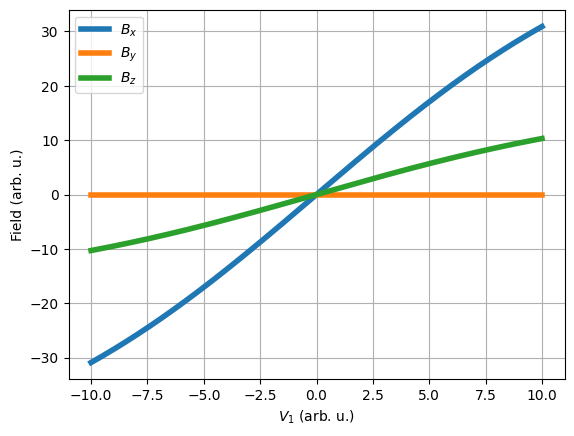

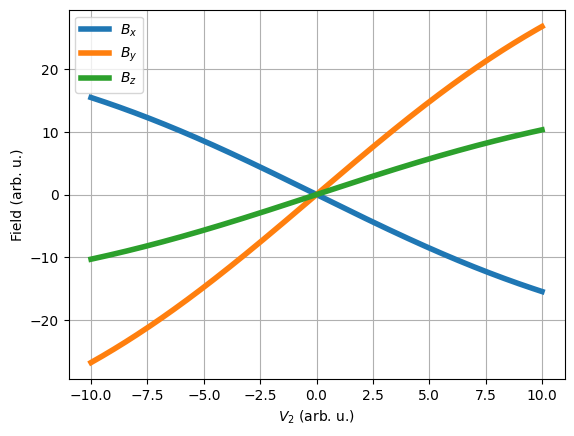

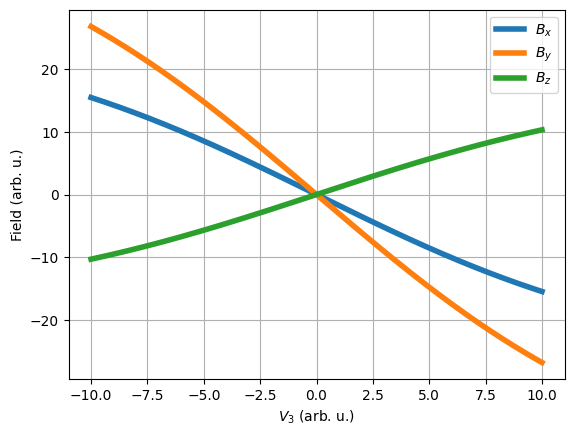

In [4]:
ax1 = B_vs_V(V1, Bx, By, Bz)
ax1.set_xlabel(r'$V_1$ (arb. u.)')

ax2 = B_vs_V(V2, Bx, By, Bz)
ax2.set_xlabel(r'$V_2$ (arb. u.)')

ax3 = B_vs_V(V3, Bx, By, Bz)
ax3.set_xlabel(r'$V_3$ (arb. u.)')

## 'Deep' learning

### Load and prepare data

In [5]:
# Training data
df_train = pd.read_csv('data/full_calibration_set.csv')
V_train = df_train[['V_1', 'V_2', 'V_3']]
B_train = df_train[['B_x', 'B_y', 'B_z']]

# Validation data
df_val = pd.read_csv('data/validation_set.csv')
V_val = df_val[['V_1', 'V_2', 'V_3']]
B_val = df_val[['B_x', 'B_y', 'B_z']]

### Create and train neural network

In [14]:
# Initialize model
model = keras.models.Sequential([
    keras.layers.Dense(3),
    keras.layers.Dense(16,activation='tanh'),
    keras.layers.Dense(3)
])

In [15]:
# Compile model
model.compile(loss="mse", optimizer = keras.optimizers.Adam(), metrics=["mae"])

In [16]:
# Add callbacks

# Stops training if the mean absolute error does not improve for 300 epochs
early_stopping_cb = keras.callbacks.EarlyStopping(patience=200, monitor='val_mae',restore_best_weights=True)
# Adjust learning rate is performance is not improving
learning_rate_cb = keras.callbacks.ReduceLROnPlateau(monitor='val_loss',factor=0.1,patience=100)
# Saves the best model
checkpoint_cb = keras.callbacks.ModelCheckpoint(filepath="models.hdf5",save_best_only=True, monitor='val_mae')

In [17]:

# Train model
history = model.fit(B_train, V_train, epochs=2000, validation_data=(B_val, V_val),batch_size=8,callbacks=[checkpoint_cb, early_stopping_cb,learning_rate_cb ]);

Epoch 1/2000
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
206/256 [=======================>......] - ETA: 0s - loss: 13.3490 - mae: 2.5866WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x7f5fe030b310> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the 

(0.0, 0.5)

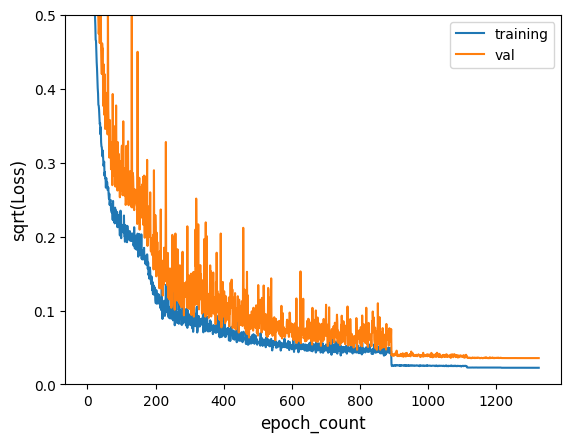

In [18]:
# Plot training process

h = history.history

training_loss = np.array(h["loss"])
test_loss = np.array(h["val_loss"])
epoch_count = np.arange(len(training_loss)) + 1

fig, ax = plt.subplots()
ax.plot(epoch_count, np.sqrt(training_loss), label='training')
ax.plot(epoch_count, np.sqrt(test_loss), label='val')
ax.set_xlabel(r'epoch_count', fontsize=12)
ax.set_ylabel(r'sqrt(Loss)', fontsize=12)
ax.legend(loc=0)
ax.set_ylim(0, 0.5)

## Test

In [19]:
# Test field
# Rotation angle
theta = np.linspace(0, 4*np.pi, 151)
B_test = []

for th in theta:
    B_test.append(1 * np.array([np.sin(th), 0, np.cos(th)]))

B_test = np.array(B_test)

In [24]:
V_test = model.predict(B_test)

nf = 15
V_test = np.tanh(V_test/nf)*10

5/5 [==============================] - 0s 1ms/step


In [25]:
M_ = np.loadtxt('data/lin_cal_mat.csv')
M = np.linalg.inv(M_)
B_predict = []
for V in V_test:
    B_predict.append(np.dot(M, V))

B_predict = np.array(B_predict)

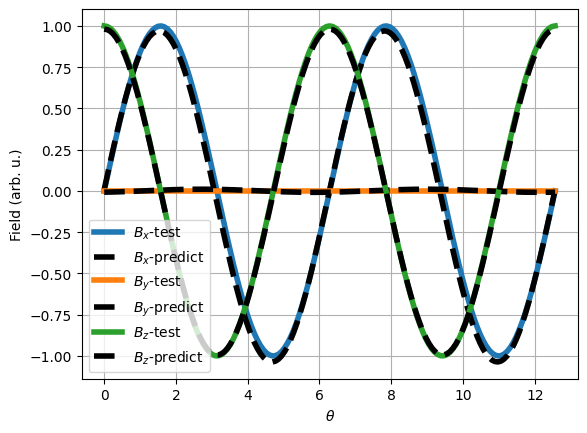

In [26]:
# Plot
fig, ax = plt.subplots()
ax.plot(theta, B_test[:,0], label=r'$B_x$-test', linewidth=4.0)
ax.plot(theta, B_predict[:,0], label=r'$B_x$-predict', linewidth=4.0, color='black', ls='--')

ax.plot(theta, B_test[:,1], label=r'$B_y$-test', linewidth=4.0)
ax.plot(theta, B_predict[:,1], label=r'$B_y$-predict', linewidth=4.0, color='black', ls='--')

ax.plot(theta, B_test[:,2], label=r'$B_z$-test', linewidth=4.0)
ax.plot(theta, B_predict[:,2], label=r'$B_z$-predict', linewidth=4.0, color='black', ls='--')

ax.set_xlabel(r'$\theta$')
ax.set_ylabel('Field (arb. u.)' )
#ax.set_xlim(0,1)
ax.legend(loc=0)
ax.grid()

In [ ]:
# Save model
model.save('data/model.h5')